# Telco customers churn

User Behaviour Analysis gives valuable insights for customer management. Especially in Telecom sector it can help find the customer churn rate. In Telecom, customer churn is to find whether the customer is going to leave the service of the current operator or not. Effective churn rate prediction is a critical task. Classification models are often used for churn rate prediction.
 
The main focus of customer churn prediction is to determinate the customers who are at risk of leaving the current operator and checking if it is worth retaining. Accurate churn prediction will help in effective customer management. The Telecom operators can leverage this to offer more customer centric services, which will lead to retaining satisfied old customers and also acquiring new customers.

In [71]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix, classification_report, precision_score, recall_score
from tensorflow.keras import callbacks
import tensorflow as tf
import seaborn as sns
import os
from utils import func # all custom functions are in this module

curr = os.getcwd()
datapath = os.path.join(curr, 'data/telco_customers_churn.xls')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
df = pd.read_csv(datapath)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The dataset includes following information:
* Customers who left within the last month (Churn)
* Services that each customers has signed up for (phone, multiple lines, internet, tech support, streaming TV, ...)
* Customers account information (payment method, monthly charges, ...)
* Demographic info about customers (gender, senior, partners, dependents)

As we can see there are lots of categorical columns.
We have only 3 numerical columns : 
* `tenure`
* `MonthlyCharges`
* `TotalCharges`

First of all we have to convert `TotalCharges` to a numerical type

In [5]:
# replace with NaN if there are parsing errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce') 

We can look if we have others NaN values in the dataset

In [6]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We have only 11 NaN values in our dataset, we can choose to fill them or to get rid of these rows

In [7]:
df[df['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


We see that there are NaN values when the customer's tenure is equal to 0. Besides, all of them are non-churned customers.  
**So we can infer these are new customers that didn't have been charged yet.**   
Hence, we can replace the Nan values by the `MonthlyCharges`, because `TotalCharges = MonthlyCharges * tenure`

**EDIT :**  we can also replace the NaN values by 0, both are correct

In [8]:
df = df.apply(func.fillNan, axis = 1)

In [9]:
df['TotalCharges'].isnull().sum()

0

In [10]:
print(f' we have {df.shape[0]} samples')

 we have 7043 samples


We can get rid of the id column because it does not convey any useful information

In [11]:
df = df.drop(['customerID'], axis = 1)

Lets then visualize some variables from the dataset (categoricals and numericals).

## Visualization

<AxesSubplot:xlabel='Churn'>

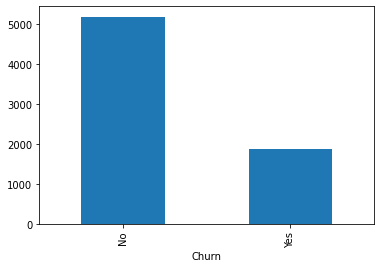

In [12]:
df.groupby('Churn').size().plot(kind = 'bar')

**the dataset is clearly imbalanced, we have to take that into account when we will build models**

### Categorical columns

#### Gender

Male      3555
Female    3488
Name: gender, dtype: int64 

 Female : churned customers : 0.269
 Male : churned customers : 0.262


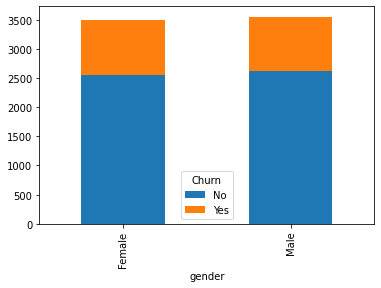

In [13]:
func.visualize(df, df['gender'], df['Churn'])

Gender does not seem to have an impact on the churn

#### Partner

No     3641
Yes    3402
Name: Partner, dtype: int64 

 No : churned customers : 0.330
 Yes : churned customers : 0.197


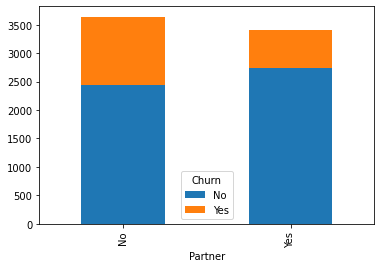

In [14]:
func.visualize(df, df['Partner'], df['Churn'])

Wether the customer has partner or not does seem to have a slightly effect on the churn

#### Dependents

No     4933
Yes    2110
Name: Dependents, dtype: int64 

 No : churned customers : 0.313
 Yes : churned customers : 0.155


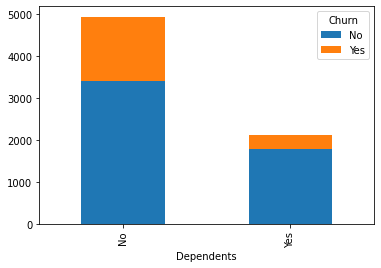

In [15]:
func.visualize(df, df['Dependents'], df['Churn'])

Customers that have no dependents are more likely to churn 

#### PhoneService

Yes    6361
No      682
Name: PhoneService, dtype: int64 

 No : churned customers : 0.249
 Yes : churned customers : 0.267


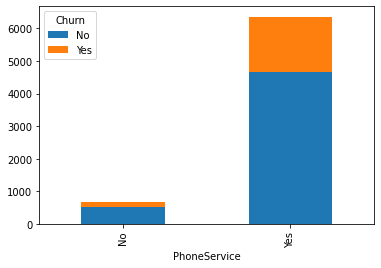

In [16]:
func.visualize(df, df['PhoneService'], df['Churn'])

Almost all customers have sign up for the phone service.

#### MultipleLines

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 

 No : churned customers : 0.250
 No phone service : churned customers : 0.249
 Yes : churned customers : 0.286


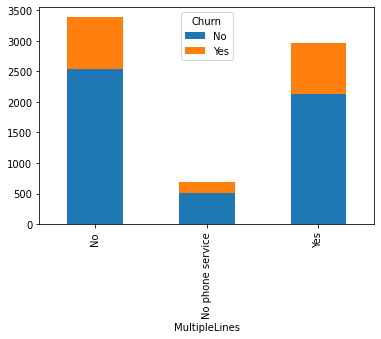

In [17]:
func.visualize(df, df['MultipleLines'], df['Churn'])

Whether customer signed for multiple lines or not does not seem to have an effect on the churn

#### InternetService

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

 DSL : churned customers : 0.190
 Fiber optic : churned customers : 0.419
 No : churned customers : 0.074


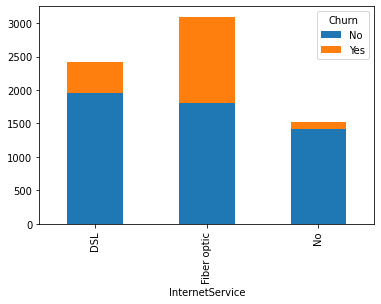

In [18]:
func.visualize(df, df['InternetService'], df['Churn'])

There is a huge amount of churned customers among those which have the fiber optic set up (almost 50 %)

#### OnlineSecurity

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64 

 No : churned customers : 0.418
 No internet service : churned customers : 0.074
 Yes : churned customers : 0.146


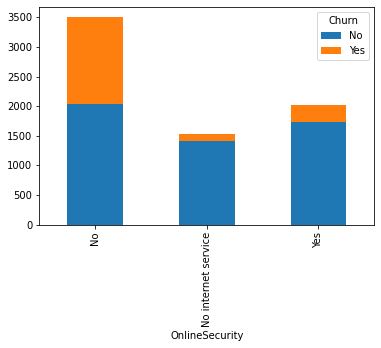

In [19]:
func.visualize(df, df['OnlineSecurity'], df['Churn'])

Customers who did not sign up for Online security service are most likely to churn

#### OnlineBackup

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64 

 No : churned customers : 0.399
 No internet service : churned customers : 0.074
 Yes : churned customers : 0.215


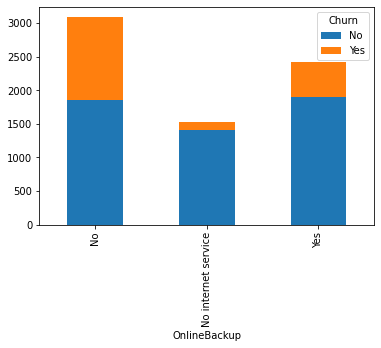

In [20]:
func.visualize(df, df['OnlineBackup'], df['Churn'])

Customers who did not sign up for Online backup service are most likely to churn

#### DeviceProtection

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64 

 No : churned customers : 0.391
 No internet service : churned customers : 0.074
 Yes : churned customers : 0.225


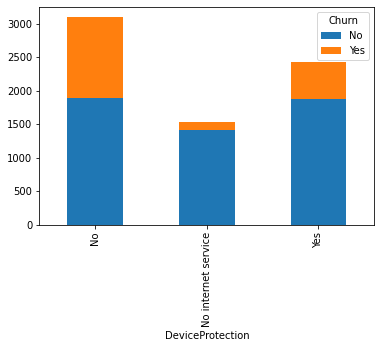

In [21]:
func.visualize(df, df['DeviceProtection'], df['Churn'])

Customers who did not sign up for the device protection service are most likely to churn

#### TechSupport

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64 

 No : churned customers : 0.416
 No internet service : churned customers : 0.074
 Yes : churned customers : 0.152


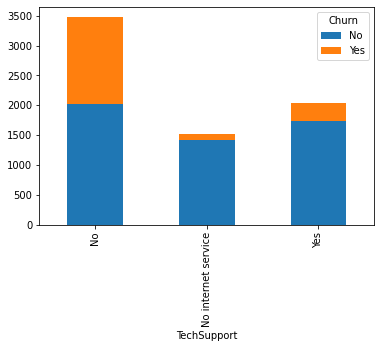

In [22]:
func.visualize(df, df['TechSupport'], df['Churn'])

Customers who did not sign up for a tech support service are most likely to churn

#### StreamingTV

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64 

 No : churned customers : 0.335
 No internet service : churned customers : 0.074
 Yes : churned customers : 0.301


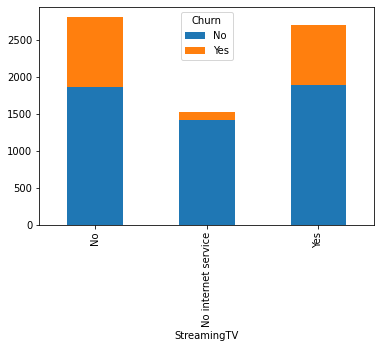

In [23]:
func.visualize(df, df['StreamingTV'], df['Churn'])

#### StreamingMovies

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64 

 No : churned customers : 0.337
 No internet service : churned customers : 0.074
 Yes : churned customers : 0.299


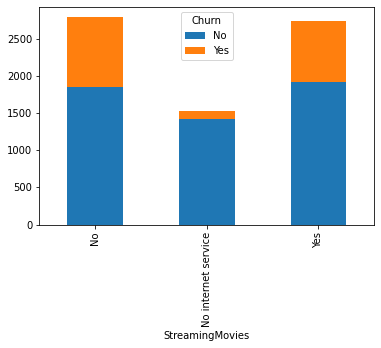

In [24]:
func.visualize(df, df['StreamingMovies'], df['Churn'])

**From all above services, we can see that customers with no internet services have a very low churn rate**

#### Contract

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64 

 Month-to-month : churned customers : 0.427
 One year : churned customers : 0.113
 Two year : churned customers : 0.028


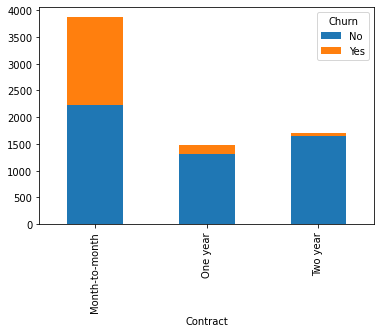

In [25]:
func.visualize(df, df['Contract'], df['Churn'])

It is obvious that contract term does have an effect on churn. There were very few churns when customers have a two-year contract. And most churns occurred on customers with a month-to-month contract.  
It is a commercial strategy for a company to renew long term contracts with its customers

#### PaperlessBilling

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64 

 No : churned customers : 0.163
 Yes : churned customers : 0.336


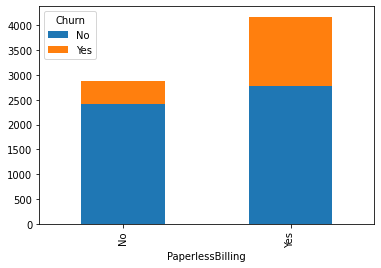

In [26]:
func.visualize(df, df['PaperlessBilling'], df['Churn'])

#### PaymentMethod

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64 

 Bank transfer (automatic) : churned customers : 0.167
 Credit card (automatic) : churned customers : 0.152
 Electronic check : churned customers : 0.453
 Mailed check : churned customers : 0.191


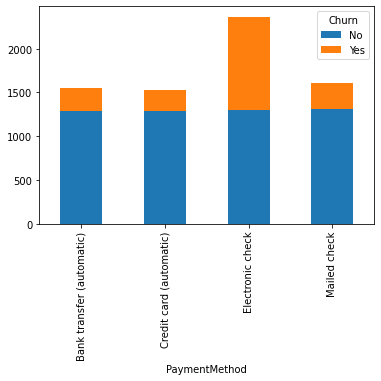

In [27]:
func.visualize(df, df['PaymentMethod'], df['Churn'])

#### SeniorCitizen

0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

 0 : churned customers : 0.236
 1 : churned customers : 0.417


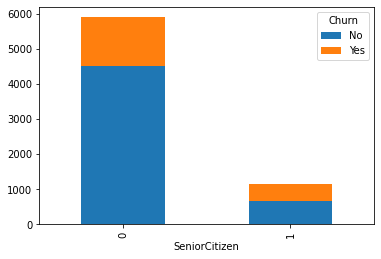

In [28]:
func.visualize(df, df['SeniorCitizen'], df['Churn'])

We do not have many senior citizens in the data. But Senior are more likely to churn (almost 50 %).

### Numerical columns

Instead of plotting a raw histogram, we will plot the density estimation of these variables.  
We will so use an unsupervised machine learning method, which is the Kernel Density Estimation (KDE).

#### Tenure

number of months the customer has stayed with the company

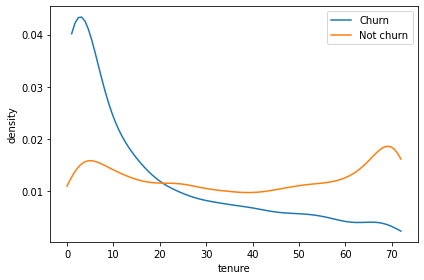

In [29]:
data_churn, data_notchurned = func.plot_density_estimator_1D(df, df['tenure'])

If a company wants to gain customers, it has to retain them within the first few months

In [30]:
data_churn.describe()

,tenure
count,1869.000000
mean,17.979133
std,19.531123
min,1.000000
25%,2.000000
50%,10.000000
75%,29.000000
max,72.000000


In [31]:
data_notchurned.describe()

,tenure
count,5174.000000
mean,37.569965
std,24.113777
min,0.000000
25%,15.000000
50%,38.000000
75%,61.000000
max,72.000000


Not churned customers have a much longer average tenure (37 months) than the churned customers. Makes sense.

#### Monthly charges

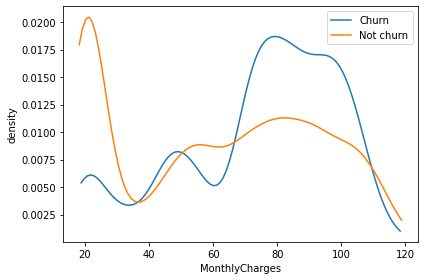

In [32]:
data_churn, data_notchurned = func.plot_density_estimator_1D(df, df['MonthlyCharges'])

In [33]:
data_churn.describe()

,MonthlyCharges
count,1869.000000
mean,74.441332
std,24.666053
min,18.850000
25%,56.150000
50%,79.650000
75%,94.200000
max,118.350000


In [34]:
data_notchurned.describe()

,MonthlyCharges
count,5174.000000
mean,61.265124
std,31.092648
min,18.250000
25%,25.100000
50%,64.425000
75%,88.400000
max,118.750000


Churned customers paid over 20% higher on average monthly fee than non-churned customers.

#### Total Charges

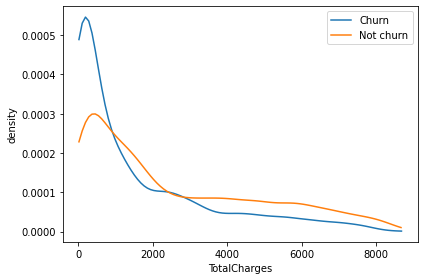

In [35]:
data_churn, data_notchurned = func.plot_density_estimator_1D(df, df['TotalCharges'])

There is a possibility that the dataset contains some outliers. Indeed, above curves show that the distribution of numerical variables are not normal. Let's verify this by using boxplot.

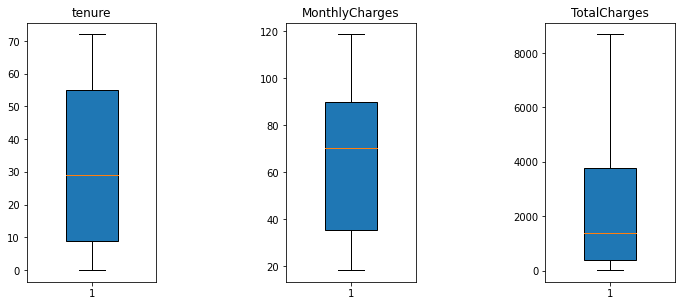

In [36]:
func.plot_boxplots(df)

Outliers are spotted by this kind of graph because it shows data points that are less than (Q1 - 1.5 IQR) and greater than (Q3 + 1.5 IQR).  
Hopefully this is not the case for our dataset : we don't have any outliers.

According to the visualization step, variables which seem highly correlated to the churn rate are :
* `Contract`
* `InternetService`
* `OnlineSecurity`
* `SeniorCitizen`
* `TechSupport`
* `PaperlessBilling`
* `PaymentMethod`
* all numericals variables

Let's try to see if we can get some insights from a correlation plot

In [37]:
# convert Churn variable to a categorical variable
df['Churn'] = df['Churn'].map({'No': 0,'Yes': 1}) 
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.102997,0.150889
tenure,0.016567,1.000000,0.247900,0.826164,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651182,0.193356
TotalCharges,0.102997,0.826164,0.651182,1.000000,-0.198347
Churn,0.150889,-0.352229,0.193356,-0.198347,1.000000


There is nothing new under the hood, the `SeniorCitizen` variable isn't really related to any of numerical variables, the `tenure` variable is indeed correlated to the `TotalCharges` and to the `Churn` variable (negative correlation). `MonthlyCharges` is correlated to `TotalCharges` and this latest is highly correlated to `MonthlyCharges` and `tenure`. Makes perfectly sense. 

At a first glance, the `Churn` variable seems to share a negative correlation with `tenure`

## Categorical features

We now need to encode each of these categorical variable into numbers:
* Variables with only 2 categories are encoded into 0 and 1
*  Others variables are encoded using one hot encoding  

**EDIT :** Instead of one hot encode some variables, we could just encode with multilabels (0, 1, 2) or even merge 2 labels which have the same meaning into one single labels, but I think it is more meaningful to one hot encode because we end up with more features.

**EDIT :** One other way to encode categorical variables would be to use their frequencies

In [38]:
categorical =  ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for c in categorical:
    one, two = df.groupby(c).size().index
    df[c] = df[c].map({one: 0, two: 1}) # 0 = No/Female     1 = Yes/Male

multiples = ['MultipleLines','InternetService', 'OnlineSecurity', 
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'Contract', 'PaymentMethod']

# one hot encode
for c in multiples:
    dummies = pd.get_dummies(df[c], prefix = c, prefix_sep = '_')
    df.drop([c], inplace = True, axis = 1)
    df = pd.concat([df, dummies], axis = 1)

In [39]:
len(df.columns)

41

And we can plot another correlation map

In [40]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.011754,-0.014569,-0.000087,-0.008612,0.004476,0.006488,-0.008414,0.006568,-0.011286,0.006026,0.010429,0.006026,-0.017021,0.008191,0.006026,-0.013773,-0.002988,0.006026,-0.002105,0.003397,0.006026,-0.009212,0.003267,0.006026,-0.008393,0.005374,0.006026,-0.010487,-0.003386,0.008026,-0.003695,-0.016024,0.001215,0.000752,0.013744
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.156530,0.220173,0.102997,0.150889,-0.136213,-0.008576,0.142948,-0.108322,0.255338,-0.182742,0.185532,-0.182742,-0.038653,0.087952,-0.182742,0.066572,0.094810,-0.182742,0.059428,0.205620,-0.182742,-0.060625,0.049062,-0.182742,0.105378,0.034210,-0.182742,0.120176,0.138360,-0.046262,-0.117000,-0.016159,-0.024135,0.171718,-0.153477
Partner,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,-0.014877,0.096848,0.317532,-0.150448,-0.129929,-0.017706,0.142057,-0.000851,0.000304,0.000615,-0.129936,0.000615,0.143106,-0.136058,0.000615,0.141498,-0.147692,0.000615,0.153786,-0.109443,0.000615,0.119999,-0.124357,0.000615,0.124666,-0.117529,0.000615,0.117412,-0.280865,0.082783,0.248091,0.110706,0.082029,-0.083852,-0.095125
Dependents,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.111377,-0.113890,0.062124,-0.164221,0.023198,0.001762,-0.024526,0.052010,-0.165818,0.139812,-0.188434,0.139812,0.080972,-0.138756,0.139812,0.023671,-0.129415,0.139812,0.013963,-0.172645,0.139812,0.063268,-0.101176,0.139812,-0.016558,-0.078198,0.139812,-0.039741,-0.231720,0.068368,0.204613,0.052021,0.060267,-0.150642,0.059071
tenure,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.006152,0.247900,0.826164,-0.352229,-0.323088,-0.008448,0.331941,0.013274,0.019720,-0.039062,-0.263746,-0.039062,0.327203,-0.312694,-0.039062,0.360277,-0.312740,-0.039062,0.360653,-0.262143,-0.039062,0.324221,-0.245039,-0.039062,0.279756,-0.252220,-0.039062,0.286111,-0.645561,0.202570,0.558533,0.243510,0.233006,-0.208363,-0.233852
PhoneService,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,0.016505,0.247398,0.113203,0.011942,0.315431,-1.000000,0.279690,-0.452425,0.289999,0.172209,-0.057880,0.172209,-0.092893,-0.092867,0.172209,-0.052312,-0.074776,0.172209,-0.071227,-0.054447,0.172209,-0.096340,-0.122455,0.172209,-0.022574,-0.112254,0.172209,-0.032959,-0.000742,-0.002791,0.003519,0.007556,-0.007721,0.003062,-0.003319
PaperlessBilling,-0.011754,0.156530,-0.014877,-0.111377,0.006152,0.016505,1.000000,0.352150,0.158562,0.191825,-0.151864,-0.016505,0.163530,-0.063121,0.326853,-0.321013,0.267793,-0.321013,-0.003636,0.145120,-0.321013,0.126735,0.167121,-0.321013,0.103797,0.230136,-0.321013,0.037880,0.047712,-0.321013,0.223841,0.059488,-0.321013,0.211716,0.169096,-0.051391,-0.147889,-0.016332,-0.013589,0.208865,-0.205398
MonthlyCharges,-0.014569,0.220173,0.096848,-0.113890,0.247900,0.247398,0.352150,1.000000,0.651182,0.193356,-0.338314,-0.247398,0.490434,-0.160189,0.787066,-0.763557,0.360898,-0.763557,0.296594,0.210753,-0.763557,0.441780,0.171836,-0.763557,0.482692,0.322076,-0.763557,0.338304,0.016951,-0.763557,0.629603,0.018075,-0.763557,0.627429,0.060165,0.004904,-0.

According to the correlation map, the features that could explain the churn are:
* `InternetService_Fiber optic`
* `OnlineSecurity_No`
* `TechSupport_No`
* `Contract_Month-to-month`
* `PaymentMethod_Electronic check`

It is more or less what we have conclude in the visualization part.  
Now let's feed a `RandomForestClassifier` to see if we end up with the same results.  
First of all, we have to tackle the problem of the imbalanced dataset. So, we will use class weight

In [41]:
# we will use class weights to adress the problem of the imbalanced dataset
# without class weights, SGD optimization may have convergence issues and the gradient will push strongly in the 
# direction of the overrepresented class
counts = df['Churn'].value_counts(normalize = True)
total = counts[0] + counts[1]

# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_churn = (1 / counts[1]) * (total) / 2.0
weight_non_churn = (1 / counts[0]) * (total) / 2.0

class_weight = {0: weight_non_churn, 1: weight_churn}

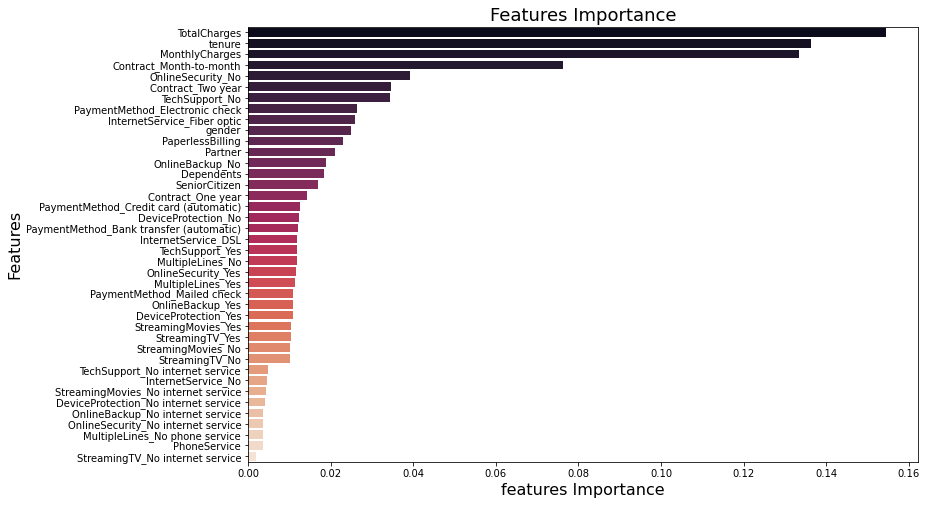

In [42]:
classifier = RandomForestClassifier(random_state = 4, n_estimators = 200, class_weight = class_weight)

X = df.drop(columns = ['Churn']) # all the features 
Y = df['Churn'] # the target

features = classifier.fit(X, Y).feature_importances_

features = pd.Series(data = features, index = X.columns).sort_values(ascending = False)
plt.figure(figsize = (12,8))
plt.title('Features Importance', fontsize = 18)
ax = sns.barplot(y = features.index, x = features.values, palette = 'rocket', orient = 'h')
ax.set_xlabel('features Importance',fontsize = 16);
ax.set_ylabel('Features',fontsize = 16);
plt.show()

According to the classifier the most important features are:
* `TotalCharges`
* `tenure`
* `MonthlyCharges`
* `Contract-Month-to-month`

It is interesting that the classifier tends to give high importance to features related to money, instead to features related to the quality of the service (and quite surprising)

## spliting and standardization

Now that we have explored the dataset, we can split it into 3 sets:
* the training set 
* the validation set
* the test set

And then we will standardize all data according to those from the training set

In [43]:
inputs = df.columns[df.columns != 'Churn'] # the features

In [44]:
X_tr, X_vl, Y_tr, Y_vl = train_test_split(df[inputs], df['Churn'], test_size = 0.2, random_state = 45)

scaler = StandardScaler()

# we train the scaler only on the training set and we standardize it
X_tr = scaler.fit_transform(X_tr) 

# we resplit the validation set obtained before into a validation and test set
X_vl, X_ts, Y_vl, Y_ts = train_test_split(X_vl, Y_vl, test_size = 0.4, random_state = 45)

# we standardize as well these sets but based on training information alone
X_vl = scaler.transform(X_vl) 
X_ts = scaler.transform(X_ts)

X_tr.shape, X_vl.shape, X_ts.shape

((5634, 40), (845, 40), (564, 40))

## Churn prediction as a classification task

We will begin by tackle the problem as a classification task

inputs : all features  
target : churn or not churned

### A simple approach

We will use 3 base models for this classification task
* `AdaBoostClassifier`
* `LogisticRegression`
* `RandomForestClassifier`

In [45]:
# class weight to balance the imbalanced dataset
models = {
    'ada':AdaBoostClassifier(), # unfortunately, we AdaBoost doesn't have a class_weight parameter
    'lr':LogisticRegression(class_weight = class_weight),
    'rfc':RandomForestClassifier(class_weight = class_weight)
}

# this time we will try to tune hyperparameters
ada_params = {
    'n_estimators':[80, 90, 100, 200],
    'learning_rate':[0.8, 0.9]
}

lr_params = {
    'C': np.arange(0.5, 1, 0.1),
    'max_iter':[500, 1000],
}

rfc_params = {
    'n_estimators':[80, 90, 100, 200],
    'min_samples_leaf':range(1,5),
}

params = [ada_params, lr_params, rfc_params]

In [46]:
# we use the validation set to tune hyperparameters
bestparams, best_scores = func.grid_search_selector([X_tr, Y_tr], [X_vl, Y_vl], models, params)

ada -- 0.8094674556213017
lr -- 0.7538461538461538
rfc -- 0.8011834319526627


report on the test set : 
              precision    recall  f1-score   support

 Non-churned       0.85      0.89      0.87       409
     Churned       0.67      0.58      0.62       155

    accuracy                           0.80       564
   macro avg       0.76      0.74      0.74       564
weighted avg       0.80      0.80      0.80       564

 test set accuracy non-churned customers : 0.8900
 test set accuracy churned customers : 0.5806


c:\users\coren\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


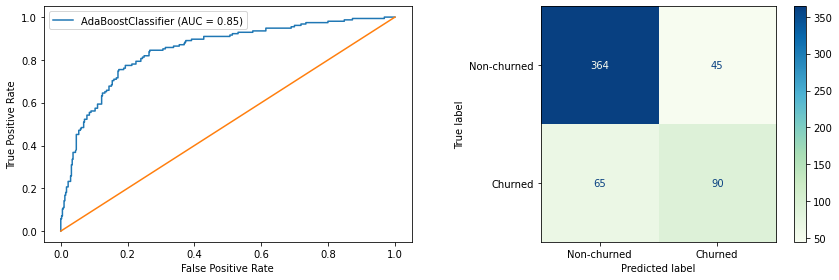

In [47]:
ada_model = func.model_evaluation(models['ada'], bestparams['ada'], [X_tr, Y_tr], [X_ts, Y_ts])

report on the test set : 
              precision    recall  f1-score   support

 Non-churned       0.93      0.70      0.80       409
     Churned       0.52      0.86      0.65       155

    accuracy                           0.74       564
   macro avg       0.72      0.78      0.72       564
weighted avg       0.82      0.74      0.75       564

 test set accuracy non-churned customers : 0.6968
 test set accuracy churned customers : 0.8581


c:\users\coren\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


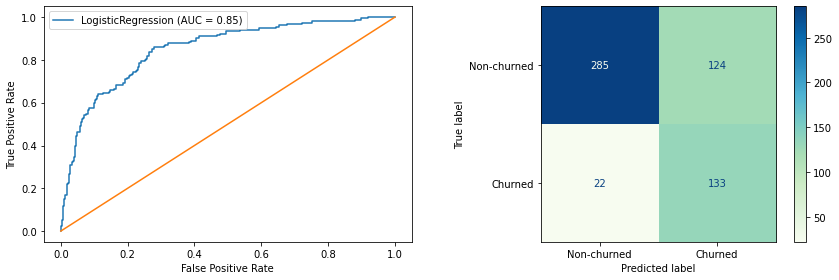

In [48]:
lr_model = func.model_evaluation(models['lr'], bestparams['lr'], [X_tr, Y_tr], [X_ts, Y_ts])

report on the test set : 
              precision    recall  f1-score   support

 Non-churned       0.83      0.90      0.86       409
     Churned       0.66      0.52      0.58       155

    accuracy                           0.79       564
   macro avg       0.75      0.71      0.72       564
weighted avg       0.78      0.79      0.79       564

 test set accuracy non-churned customers : 0.8973
 test set accuracy churned customers : 0.5226


c:\users\coren\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


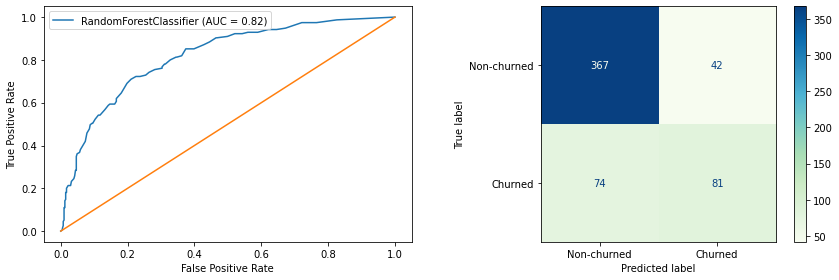

In [49]:
tfc_model = func.model_evaluation(models['rfc'], bestparams['rfc'], [X_tr, Y_tr], [X_ts, Y_ts])

As we can see the models struggle to classified churned customers (because of the imbalanced dataset) even with the class weight.

### neural approach

In [50]:
# global variables
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 10
cb = [callbacks.EarlyStopping(patience = 10, restore_best_weights = True)]
input_shape = (X_tr.shape[1],)

In [51]:
nn = func.build_classifier(input_shape = input_shape, hidden = [])

# we use class weight as well
# the loss is binary_crossentropy with the adam optimizer
history = nn.fit(X_tr, Y_tr, validation_data = (X_vl, Y_vl), 
                 callbacks = cb, 
                 batch_size = BATCH_SIZE, 
                 epochs = EPOCHS, 
                 verbose = 1, 
                 class_weight = class_weight
                )

Epoch 1/100
177/177 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.5983 - val_loss: 0.6153 - val_accuracy: 0.6757
Epoch 2/100
177/177 [==============================] - 0s 956us/step - loss: 0.5531 - accuracy: 0.6846 - val_loss: 0.5708 - val_accuracy: 0.7101
Epoch 3/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5261 - accuracy: 0.7043 - val_loss: 0.5426 - val_accuracy: 0.7219
Epoch 4/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5126 - accuracy: 0.7185 - val_loss: 0.5259 - val_accuracy: 0.7290
Epoch 5/100
177/177 [==============================] - 0s 957us/step - loss: 0.5050 - accuracy: 0.7247 - val_loss: 0.5162 - val_accuracy: 0.7408
Epoch 6/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5005 - accuracy: 0.7274 - val_loss: 0.5084 - val_accuracy: 0.7456
Epoch 7/100
177/177 [==============================] - 0s 862us/step - loss: 0.4977 - accuracy: 0.7306 - val_loss: 0.5021 - val_accuracy: 

final loss : 0.4891 (training), 0.4867 (validation)


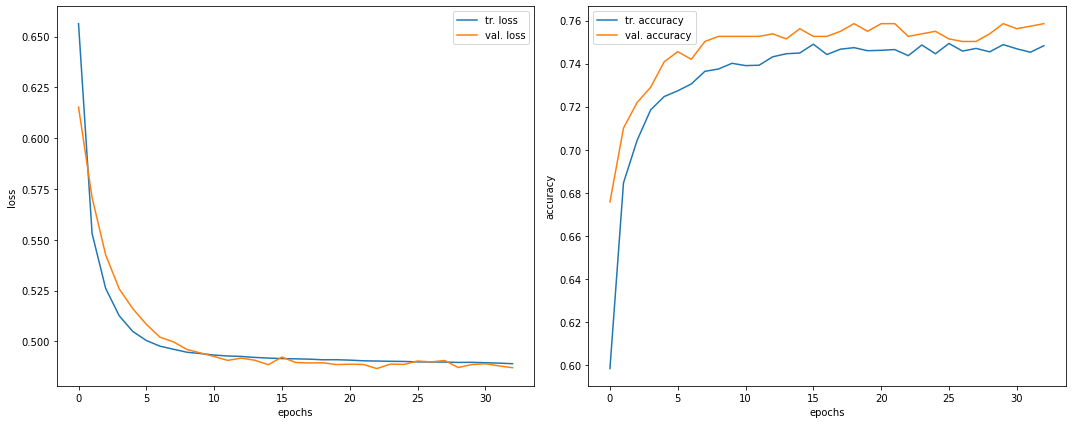

In [52]:
func.plot_training_history(history)

In [53]:
# let's build a deeper model to see if we can do better
nn2 = func.build_classifier(input_shape = input_shape, hidden = [32, 32])

nn2.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')
history2 = nn2.fit(X_tr, Y_tr, validation_data = (X_vl, Y_vl), 
                   callbacks = cb, 
                   batch_size = BATCH_SIZE, 
                   epochs = EPOCHS, 
                   verbose = 1, 
                   class_weight = class_weight)

Epoch 1/100
177/177 [==============================] - 0s 2ms/step - loss: 0.5556 - accuracy: 0.7071 - val_loss: 0.4949 - val_accuracy: 0.7444
Epoch 2/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4998 - accuracy: 0.7291 - val_loss: 0.4965 - val_accuracy: 0.7527
Epoch 3/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4873 - accuracy: 0.7405 - val_loss: 0.4945 - val_accuracy: 0.7527
Epoch 4/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4815 - accuracy: 0.7394 - val_loss: 0.4735 - val_accuracy: 0.7657
Epoch 5/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4764 - accuracy: 0.7529 - val_loss: 0.4839 - val_accuracy: 0.7574
Epoch 6/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.7472 - val_loss: 0.4733 - val_accuracy: 0.7621
Epoch 7/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4693 - accuracy: 0.7570 - val_loss: 0.5070 - val_accuracy: 0.7337

final loss : 0.4451 (training), 0.4733 (validation)


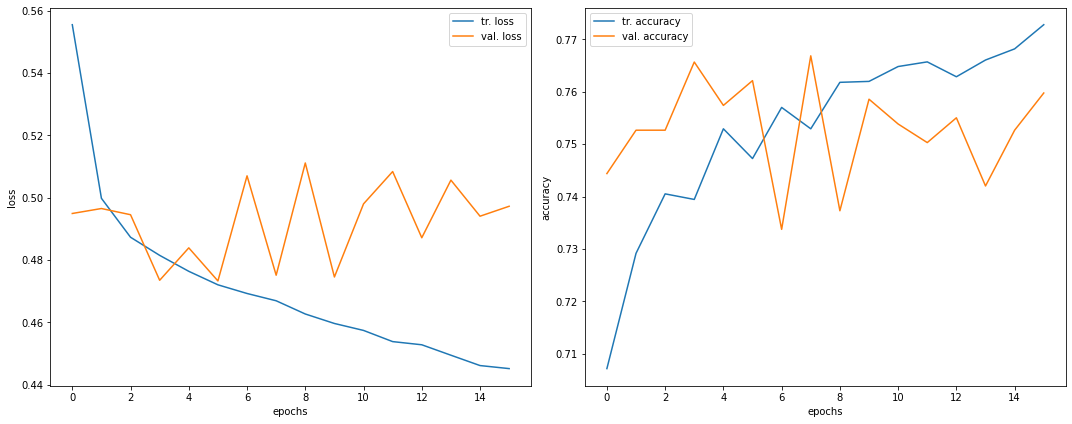

In [54]:
func.plot_training_history(history2)

Increase the depth of the model has paid off a bit

The main metric is just the accuracy, as the true positif rate is the only one we really care about

In [55]:
tr_nn_score, tr_nn_metric = func.compute_metric(X_tr, Y_tr, nn)
tr_nn2_score, tr_nn2_metric = func.compute_metric(X_tr, Y_tr, nn2)

ts_nn_score, ts_nn_metric = func.compute_metric(X_ts, Y_ts, nn)
ts_nn2_score, ts_nn2_metric = func.compute_metric(X_ts, Y_ts, nn2)

print('==== MODEL 1 =====')
print(f'TRAINING \n accuracy : {tr_nn_metric} \n non-churned : {tr_nn_score[0]:.3f} \n churn : {tr_nn_score[1]:.3f}')
print(f'TESTING \n accuracy : {ts_nn_metric}\n non-churned : {ts_nn_score[0]:.3f} \n churn : {ts_nn_score[1]:.3f} ')
print('=================')
print()
print('==== MODEL 2 =====')
print(f'TRAINING \n accuracy : {tr_nn2_metric} \n non-churned : {tr_nn2_score[0]:.3f} \n churn : {tr_nn2_score[1]:.3f}')
print(f'TESTING \n accuracy  : {ts_nn2_metric}\n non-churned : {ts_nn2_score[0]:.3f} \n churn : {ts_nn2_score[1]:.3f}')
print('=================')

==== MODEL 1 =====
TRAINING 
 accuracy : 0.75 
 non-churned : 0.736 
 churn : 0.792
TESTING 
 accuracy : 0.74
 non-churned : 0.709 
 churn : 0.832 

==== MODEL 2 =====
TRAINING 
 accuracy : 0.77 
 non-churned : 0.765 
 churn : 0.785
TESTING 
 accuracy  : 0.76
 non-churned : 0.751 
 churn : 0.800


We have a much better accuracy than before ! The models now can correctly classify non churned and churned customers as well !

**FURTHER WORK :** try with deeper model and with a regression model

## Churn prediction as an anomaly detection task

We can also address the problem by using anomalies detection techinques.  

We have seen several methods to detect anomalies:
* KDE (density estimation approach)
* autoencoder (based on neural networks)
* flow models (advanced topic, a mixture between KDE and autoencoder)

**We will use autoencoder**

### Autoencoder

An autoencoder is deep learning’s answer to dimensionality reduction.  
The idea is pretty simple: transform the input through a series of hidden layers but ensure that the final output layer is the same dimension as the input layer. However, the intervening hidden layers have progressively smaller number of nodes (and hence, reduce the dimension of the input matrix). If the output matches or encodes the input closely, then the nodes of the smallest hidden layer can be taken as a valid dimension reduced data set.  
Formally, we typically employ an MSE loss.  
Moreover, this approach has some pro and cons regarding the KDE method:
* Neural Networks have good support for high dimensional data
* ...Plus limited overfitting and fast prediction/detection time
* However, error reconstruction can be harder than density estimation

We will train the autoencoder with data comming from non-churned customers. The model should learn some regulars patterns from these and so in the evaluation part, the model should be able to identify churn customers, as their behaviours shouldn't really match what the network learnt. We can then classify a customer as churn or not if the reconstruction error is above a fixed threshold.

### data

We have to reshape a bit the data, because the training set still contains some churn customers.

In [56]:
# 1516 churn customers
Y_tr.value_counts()

0    4118
1    1516
Name: Churn, dtype: int64

In [57]:
# we sort the dataframe so non-churned customers appear at the top
df = df.sort_values(['Churn']).reset_index(drop = True)
print(f' first churn customer : {df[df.Churn == 0].shape[0] + 1} / {df.shape[0]}')

 first churn customer : 5175 / 7043


In [58]:
# training set which contains only features from non churned customers
# we work with an autoencoder, so the input is the target as well
data_tr = df.iloc[:4000]
X_tr = data_tr[inputs]
Y_tr = data_tr['Churn']

# we need to standardize data based on the training set alone
new_scaler = StandardScaler()
X_tr = new_scaler.fit_transform(X_tr)

# we will split the remaining data into a validation and test set
# but first of all we will shuffle the dataset, to be sure that both sets contain churn and non churn customers
remaining_data = df.iloc[4000:]
remaining_data = remaining_data.sample(frac = 1, random_state = 32)

data_vl, data_ts = train_test_split(remaining_data, random_state = 24, test_size = 0.3)

Y_vl = data_vl['Churn']
X_vl = data_vl[inputs]

Y_ts = data_ts['Churn']
X_ts = data_ts[inputs]

# and at the end we need to standardize both datasets with the scaler we have trained before
X_vl = new_scaler.transform(X_vl)
X_ts = new_scaler.transform(X_ts)

# all targets with correct indices
targets = pd.concat([Y_tr, Y_vl, Y_ts])

tr_df = pd.DataFrame(X_tr, index = Y_tr.index, columns = inputs)
vl_df = pd.DataFrame(X_vl, index = Y_vl.index, columns = inputs)
ts_df = pd.DataFrame(X_ts, index = Y_ts.index, columns = inputs)

# final dataframe
ae_df = pd.concat([tr_df, vl_df, ts_df])

X_tr.shape, X_vl.shape, X_ts.shape

((4000, 40), (2130, 40), (913, 40))

#### building the autoencoder

In [59]:
# the autoencoder's input is 40 dimensional and the network try to summarize all
# information into 15 dimensions
# the loss is MSE and the optimizer is RMSProp
auto_encoder, _, _ = func.build_autoencoder(input_shape = input_shape, hidden = [15])
ae_history = auto_encoder.fit(X_tr, X_tr, validation_data = (X_vl, X_vl), 
                              callbacks = cb, 
                              batch_size = BATCH_SIZE, 
                              epochs = EPOCHS)

Epoch 1/100
125/125 [==============================] - 0s 2ms/step - loss: 0.8589 - accuracy: 0.0602 - val_loss: 0.7242 - val_accuracy: 0.1282
Epoch 2/100
125/125 [==============================] - 0s 1ms/step - loss: 0.5884 - accuracy: 0.1377 - val_loss: 0.5327 - val_accuracy: 0.1601
Epoch 3/100
125/125 [==============================] - 0s 1ms/step - loss: 0.4631 - accuracy: 0.1575 - val_loss: 0.4145 - val_accuracy: 0.1343
Epoch 4/100
125/125 [==============================] - 0s 1ms/step - loss: 0.3914 - accuracy: 0.1602 - val_loss: 0.3545 - val_accuracy: 0.1535
Epoch 5/100
125/125 [==============================] - 0s 1ms/step - loss: 0.3437 - accuracy: 0.1682 - val_loss: 0.3162 - val_accuracy: 0.1629
Epoch 6/100
125/125 [==============================] - 0s 1ms/step - loss: 0.3079 - accuracy: 0.1787 - val_loss: 0.2844 - val_accuracy: 0.1836
Epoch 7/100
125/125 [==============================] - 0s 1ms/step - loss: 0.2798 - accuracy: 0.1963 - val_loss: 0.2602 - val_accuracy: 0.2300

125/125 [==============================] - 0s 1ms/step - loss: 0.1208 - accuracy: 0.5328 - val_loss: 0.1197 - val_accuracy: 0.5610
Epoch 57/100
125/125 [==============================] - 0s 1ms/step - loss: 0.1205 - accuracy: 0.5328 - val_loss: 0.1201 - val_accuracy: 0.5512
Epoch 58/100
125/125 [==============================] - 0s 1ms/step - loss: 0.1206 - accuracy: 0.5278 - val_loss: 0.1221 - val_accuracy: 0.5540
Epoch 59/100
125/125 [==============================] - 0s 1ms/step - loss: 0.1206 - accuracy: 0.5328 - val_loss: 0.1198 - val_accuracy: 0.5502
Epoch 60/100
125/125 [==============================] - 0s 1ms/step - loss: 0.1204 - accuracy: 0.5345 - val_loss: 0.1209 - val_accuracy: 0.5376
Epoch 61/100
125/125 [==============================] - 0s 1ms/step - loss: 0.1203 - accuracy: 0.5337 - val_loss: 0.1200 - val_accuracy: 0.5300
Epoch 62/100
125/125 [==============================] - 0s 1ms/step - loss: 0.1205 - accuracy: 0.5272 - val_loss: 0.1188 - val_accuracy: 0.5817
Epoch

final loss : 0.1195 (training), 0.1183 (validation)


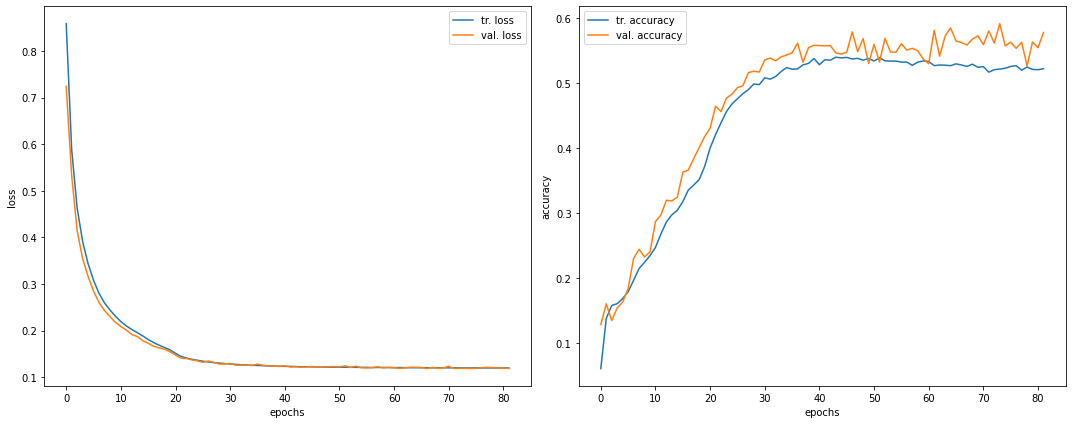

In [60]:
func.plot_training_history(ae_history)

This is an unexpected behaviour. Because the validation set contains some churn customers it should be more difficult for the network to reconstruct the input, but we see no real differences between both losses.

#### Predictions

In [61]:
predictions = auto_encoder.predict(ae_df)
preds = pd.DataFrame(index = ae_df.index, columns = ae_df.columns, data = predictions)
preds.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.078586,0.252050,-0.106090,0.063700,-0.740347,-2.900411,0.306471,-0.944308,-1.163797,-0.984703,...,1.110620,-0.608911,-0.521497,1.144549,-0.678443,-0.632683,-0.649655,-0.589823,1.609340,-0.404105
1,0.091412,-0.213590,-0.772034,-0.580046,-1.158116,0.378501,0.235950,0.438826,-0.623694,0.882057,...,0.986823,-0.601276,-0.394037,1.433335,-0.684464,-0.950880,-0.543041,-0.520787,1.383898,-0.358414
2,0.228823,-0.000611,-0.296163,-0.399062,0.308272,0.333690,0.333671,0.900508,0.721244,-0.749166,...,1.509393,-0.602206,-0.935032,0.373304,-0.581359,0.119712,-0.915934,1.442854,-0.379731,-0.146529
3,-0.068080,-0.436429,1.293096,1.137381,0.927578,0.370074,-0.361754,-0.033038,0.334833,-1.036339,...,1.255470,-0.625718,-0.667427,-0.722857,-0.631686,1.364838,1.663485,-0.614721,-0.613903,-0.434361
4,-0.232628,-0.079005,-0.414955,-0.588564,0.814514,0.314839,-0.274563,-1.232558,-0.226315,-1.134917,...,-1.003092,1.703204,-0.571768,-0.657719,-0.521561,1.186259,1.696343,-0.499297,-0.468326,-0.745920


Indeed, there are no real difference between churn and non churned customers, errors are so small

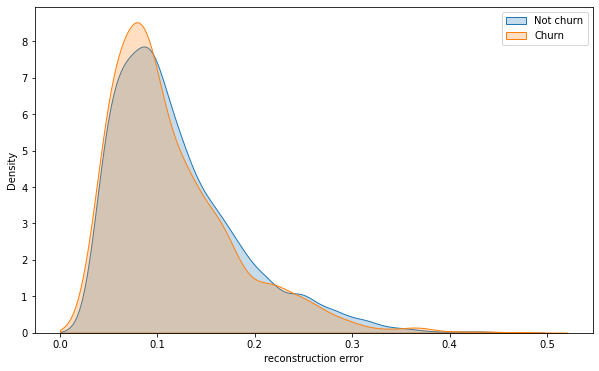

In [62]:
func.plot_reconstruction_errors(ae_df, targets, auto_encoder)

#### Alarm signal

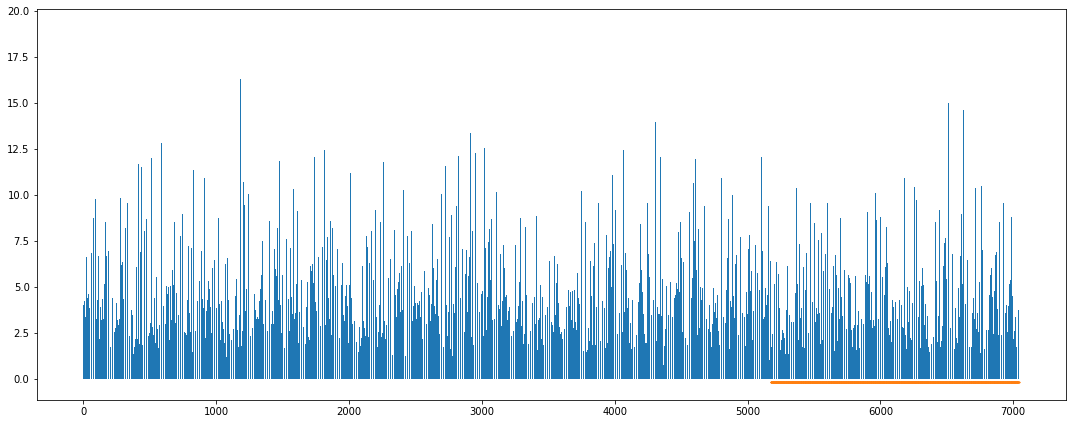

In [63]:
sse = np.sum(np.square(preds - ae_df), axis = 1) # MSE error
signal_ae = pd.Series(index = ae_df.index, data = sse)
func.plot_signal(signal_ae, targets)

Plotting the alarm signal doesn't convey any information at all. There is no real difference between non churned and churn customers.  
Maybe if we zoom we could spot some irregularities (because each observation is independant). But anyway, we have seen that reconstructions errors are too small so we can't exploit this signal (or at least it will be too hard and exhausting).

Let's display all reconstructions errors

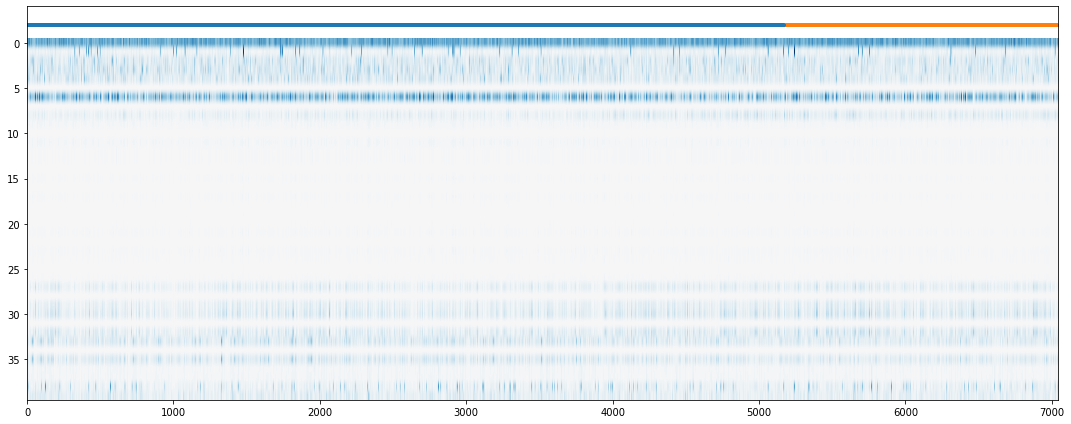

In [64]:
se = np.square(preds - ae_df)
signals_ae = pd.DataFrame(index = ae_df.index, columns = ae_df.columns, data = se)
func.plot_dataframe(signals_ae, targets)

Some features seem a bit more difficult than others, but we see no real differences between churn and non-churn customers

Let's have a closer look to reconstructed errors from a churn and a non churn customers

In [65]:
# we display the largest reconstructed errors from a non churn customer
last_non_churned = se.index[targets == 0][89]
se.iloc[last_non_churned].sort_values(ascending = False)[:8]

Dependents                               1.001353
gender                                   0.813778
Partner                                  0.238051
Contract_Month-to-month                  0.225574
Contract_Two year                        0.199690
SeniorCitizen                            0.174405
PaymentMethod_Mailed check               0.107774
PaymentMethod_Credit card (automatic)    0.078454
Name: 89, dtype: float64

In [66]:
# and we do the same for a churn customer
last_churned = se.index[targets == 1][6]
se.iloc[last_churned].sort_values(ascending = False)[:8]

gender                                     1.253422
PaperlessBilling                           0.960008
Dependents                                 0.334201
Contract_Two year                          0.111496
Contract_Month-to-month                    0.108093
tenure                                     0.085565
PaymentMethod_Mailed check                 0.061820
PaymentMethod_Bank transfer (automatic)    0.058369
Name: 4329, dtype: float64

These errors are so small, it can indeed be very difficult to spot anomalies

Here are the average errors for churn customers

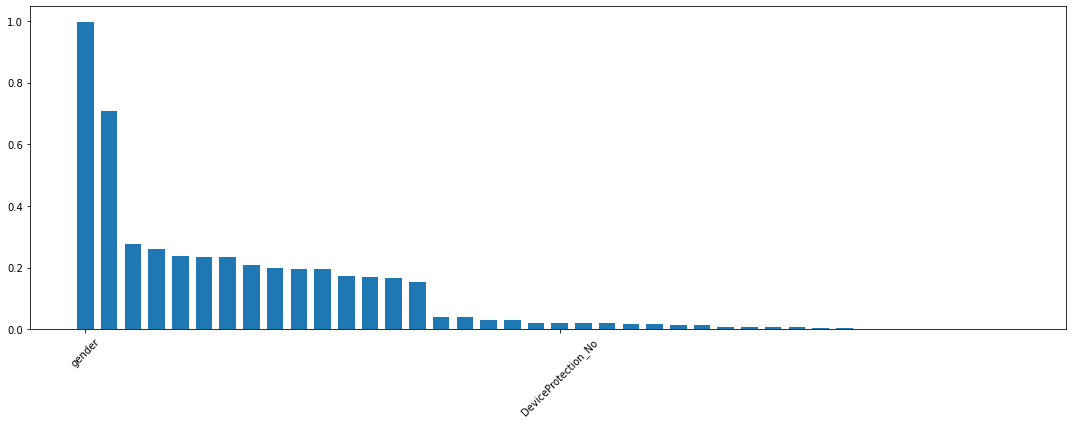

In [67]:
churn = ae_df.index[targets == 1]
tmp =  se.iloc[churn].mean().sort_values(ascending = False)
func.plot_bars(tmp, tick_gap = 20)

Errors are concentrated on 5 features

And here are the 20 largest errors for churn customers

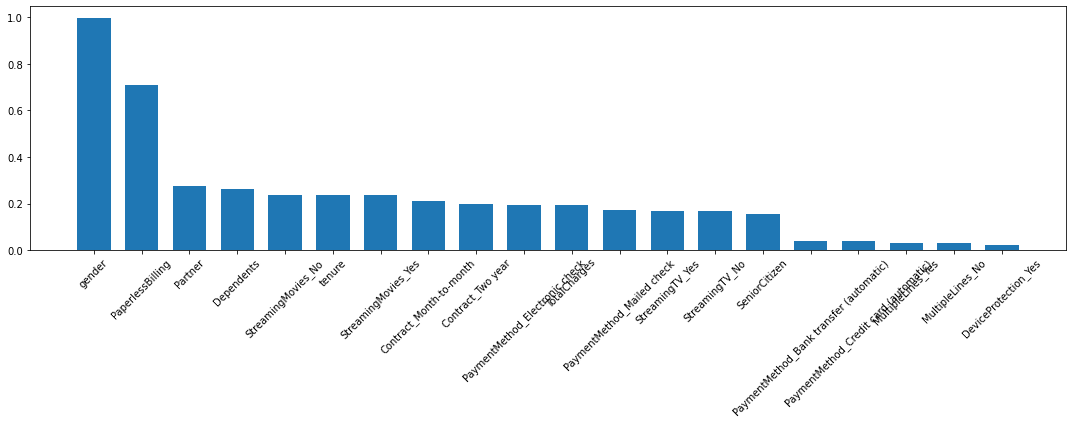

In [68]:
churn = ae_df.index[targets == 1]
tmp =  se.iloc[churn].mean().sort_values(ascending = False)
func.plot_bars(tmp.iloc[:20])

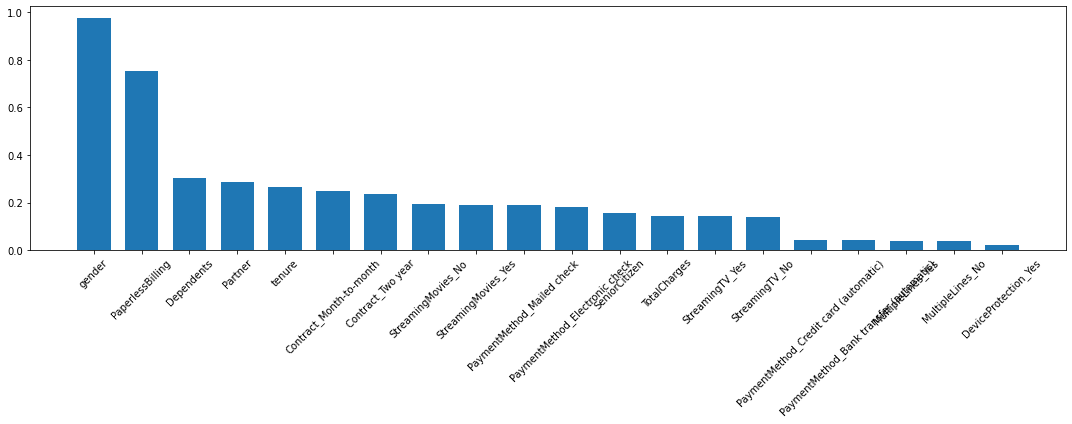

In [69]:
churn = ae_df.index[targets == 0]
tmp =  se.iloc[churn].mean().sort_values(ascending = False)
func.plot_bars(tmp.iloc[:20])

The largest errors are on `SeniorCitizen` and `PaperlessBilling`  
That a bit strange because the `InternetService` isn't in the plot even though this variable is higly correlated to the churn rate.  

Now let's choose the threshold and classify wether a customer will churn or not.

In [72]:
reconstructions = auto_encoder.predict(X_tr)
train_loss = tf.keras.losses.mae(reconstructions, X_tr)

In [73]:
# Choose a threshold value that is one standard deviations above the mean.
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.26675721414029097


In [74]:
preds = func.predict(auto_encoder, X_ts, threshold)
func.print_stats(preds, Y_ts)

Accuracy = 0.5805038335158818
Precision = 0.610608020698577
Recall = 0.851985559566787


We can then tune the threshold to have a better accuracy

### Autoencoder and latent space

We will try to visualize the latent space, and then maybe we could use a classification technique to predict if a customer will churn or not

So this time, the training set should contains both classes (churn and non churn customers)

In [75]:
# we shuffle the dataset
df = df.sample(frac = 1, random_state = 34).reset_index(drop = True)

X_tr, X_vl, Y_tr, Y_vl = train_test_split(df[inputs], df['Churn'], test_size = 0.2, random_state = 20)

scaler = StandardScaler()

# we train the scaler only on the training set and we standardize it
X_tr = scaler.fit_transform(X_tr) 

# we resplit the validation obtained before into a validation and test set
X_vl, X_ts, Y_vl, Y_ts = train_test_split(X_vl, Y_vl, test_size = 0.4, random_state = 20)

# we standardize as well these sets but based on training information alone
X_vl = scaler.transform(X_vl) 
X_ts = scaler.transform(X_ts)

X_tr.shape, X_vl.shape, X_ts.shape

((5634, 40), (845, 40), (564, 40))

In [76]:
# the latent space is 2 - dimensional
encoder_decoder, encoder, decoder = func.build_autoencoder(input_shape = input_shape, hidden = [30, 15, 2])
ae_history = encoder_decoder.fit(X_tr,X_tr, batch_size = BATCH_SIZE, 
                      validation_data = (X_vl, X_vl), 
                      epochs = EPOCHS, 
                      callbacks = cb
                     )

Epoch 1/100
177/177 [==============================] - 0s 2ms/step - loss: 0.8543 - accuracy: 0.0261 - val_loss: 0.7396 - val_accuracy: 0.0556
Epoch 2/100
177/177 [==============================] - 0s 1ms/step - loss: 0.6731 - accuracy: 0.0595 - val_loss: 0.6222 - val_accuracy: 0.0426
Epoch 3/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5829 - accuracy: 0.0541 - val_loss: 0.5734 - val_accuracy: 0.0568
Epoch 4/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5509 - accuracy: 0.0531 - val_loss: 0.5469 - val_accuracy: 0.0604
Epoch 5/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5301 - accuracy: 0.0550 - val_loss: 0.5317 - val_accuracy: 0.0343
Epoch 6/100
177/177 [==============================] - 0s 1ms/step - loss: 0.5122 - accuracy: 0.0573 - val_loss: 0.5087 - val_accuracy: 0.0663
Epoch 7/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4971 - accuracy: 0.0598 - val_loss: 0.5083 - val_accuracy: 0.1160

Epoch 58/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4146 - accuracy: 0.2714 - val_loss: 0.4198 - val_accuracy: 0.2355
Epoch 59/100
177/177 [==============================] - 0s 898us/step - loss: 0.4141 - accuracy: 0.2685 - val_loss: 0.4213 - val_accuracy: 0.2805
Epoch 60/100
177/177 [==============================] - 0s 957us/step - loss: 0.4136 - accuracy: 0.2693 - val_loss: 0.4211 - val_accuracy: 0.2450
Epoch 61/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4134 - accuracy: 0.2691 - val_loss: 0.4201 - val_accuracy: 0.2331
Epoch 62/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4132 - accuracy: 0.2657 - val_loss: 0.4103 - val_accuracy: 0.2391
Epoch 63/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4126 - accuracy: 0.2607 - val_loss: 0.4153 - val_accuracy: 0.2414
Epoch 64/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4124 - accuracy: 0.2554 - val_loss: 0.4122 - val_accur

final loss : 0.4026 (training), 0.4016 (validation)


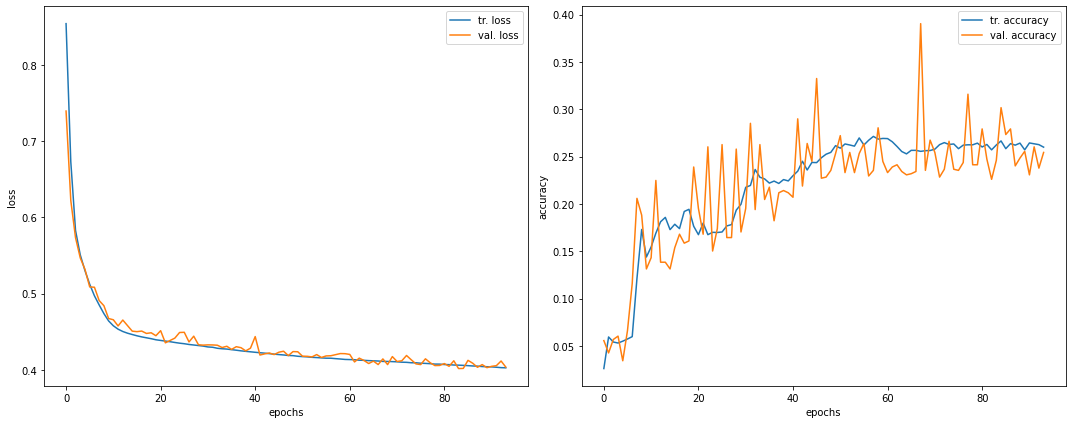

In [77]:
func.plot_training_history(ae_history)

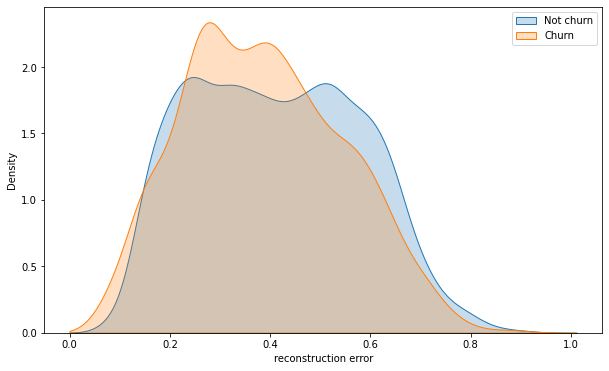

In [78]:
# reconstructions errors for the training set
func.plot_reconstruction_errors(X_tr, Y_tr, models = [encoder, decoder])

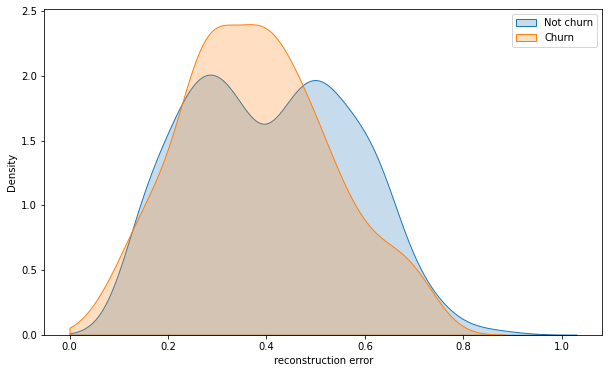

In [79]:
# reconstructions errors for the validation set
func.plot_reconstruction_errors(X_vl, Y_vl, models = [encoder, decoder])

We can cluster customers in the 2D latent space and visualize churned and not-churned customers, they can be separable at latent space and reveal the formation of distinct clusters.

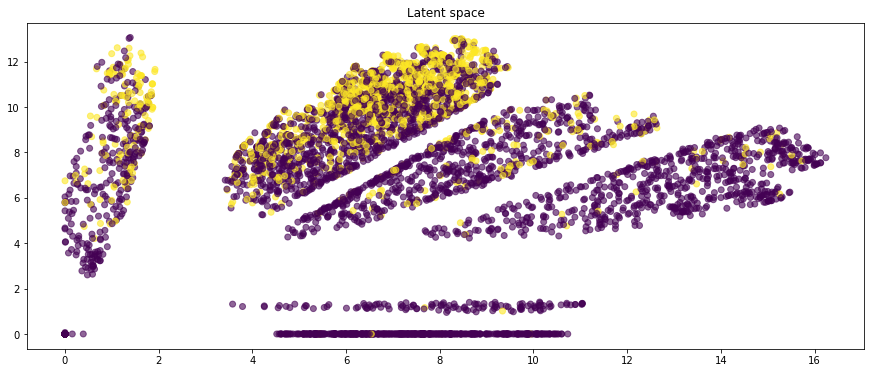

In [80]:
# latent space - training set
x_tr_encoded = func.plot_latent_space(X_tr, Y_tr, encoder)

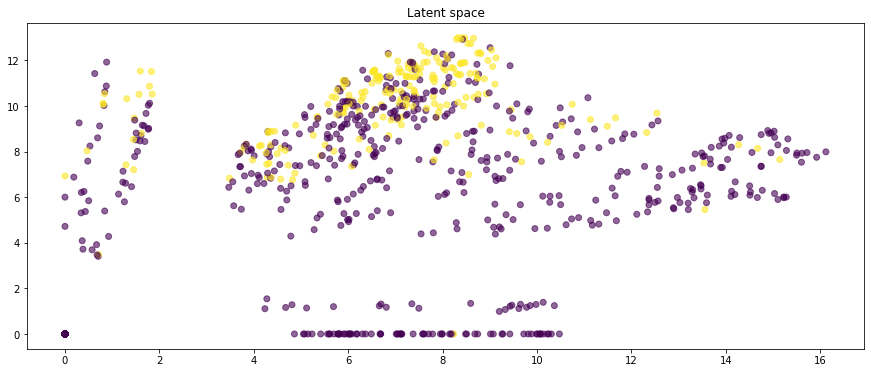

In [81]:
# latent space - validation set
x_vl_encoded = func.plot_latent_space(X_vl, Y_vl, encoder)

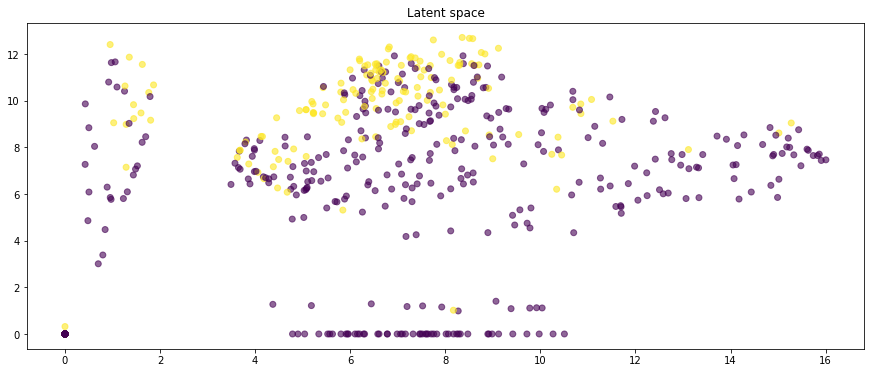

In [82]:
# latent space - test set
x_ts_encoded = func.plot_latent_space(X_ts, Y_ts, encoder)

Now that we have the latent space, let's try to classify with a simple KNN

In [83]:
knn_model = {
   'knn': KNeighborsClassifier()
}

knn_params = {
    'n_neighbors': range(5, 30)
}

In [84]:
# we use the validation set to tune hyperparameters
bestparams, best_scores = func.grid_search_selector([x_tr_encoded, Y_tr], [x_vl_encoded, Y_vl], knn_model, [knn_params])

knn -- 0.8035502958579882


report on the test set : 
              precision    recall  f1-score   support

 Non-churned       0.80      0.91      0.85       402
     Churned       0.66      0.44      0.53       162

    accuracy                           0.77       564
   macro avg       0.73      0.67      0.69       564
weighted avg       0.76      0.77      0.76       564

 test set accuracy non-churned customers : 0.9080
 test set accuracy churned customers : 0.4383


c:\users\coren\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


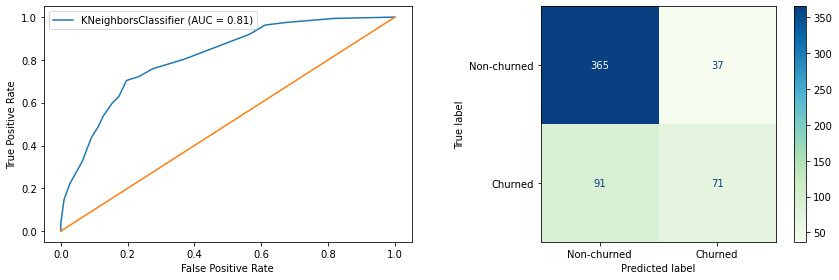

In [85]:
knn_model = func.model_evaluation(knn_model['knn'], bestparams['knn'], [x_tr_encoded, Y_tr], [x_ts_encoded, Y_ts])

C:\Users\coren\Documents\italie_AI\AI_in_industry\customer_churn\utils\func.py:330: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap = cmap_light)


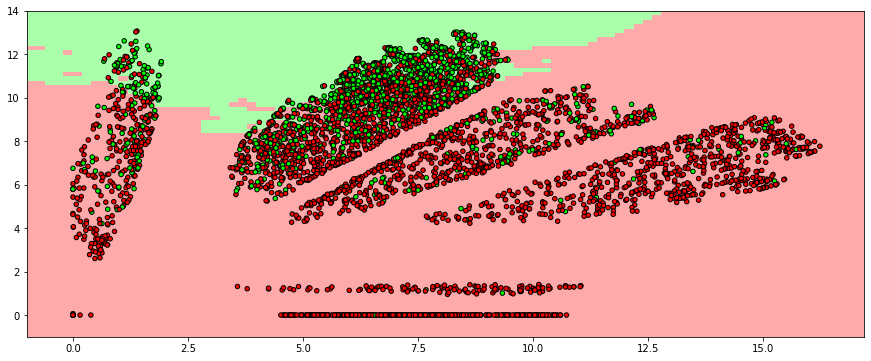

In [86]:
func.knn_visualization(x_tr_encoded, Y_tr, knn_model)

We still have the same problem that before, the classifier struggle to classify churned customers (because of the imbalanced dataset).

Because the MLP has worked well, we will try this one instead of a simple KNN algorithm.  

In [87]:
# we have to change the input shape because we are working
# with the latent space
input_shape = x_tr_encoded.shape[1] 
nn_lat = func.build_classifier(input_shape = input_shape, hidden = [])
history_lat = nn_lat.fit(x_tr_encoded, Y_tr, validation_data = (x_vl_encoded, Y_vl), 
                         callbacks = cb, 
                         batch_size = BATCH_SIZE, 
                         epochs = EPOCHS, 
                         verbose = 1, 
                         class_weight = class_weight)

Epoch 1/100
177/177 [==============================] - 1s 3ms/step - loss: 1.7923 - accuracy: 0.5044 - val_loss: 1.9432 - val_accuracy: 0.5787
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.58 - 0s 2ms/step - loss: 1.1137 - accuracy: 0.5912 - val_loss: 1.2192 - val_accuracy: 0.6438
Epoch 3/100
177/177 [==============================] - 0s 1ms/step - loss: 0.7799 - accuracy: 0.6587 - val_loss: 0.8693 - val_accuracy: 0.6840
Epoch 4/100
177/177 [==============================] - 0s 1ms/step - loss: 0.6789 - accuracy: 0.6860 - val_loss: 0.7631 - val_accuracy: 0.6947
Epoch 5/100
177/177 [==============================] - 0s 1ms/step - loss: 0.6592 - accuracy: 0.7029 - val_loss: 0.7347 - val_accuracy: 0.6982
Epoch 6/100
177/177 [==============================] - 0s 974us/step - loss: 0.6474 - accuracy: 0.7050 - val_loss: 0.7195 - val_accuracy: 0.7006
Epoch 7/100
177/177 [==============================] - 0s 988us/step - loss: 0.6350 - accuracy: 0.

final loss : 0.5278 (training), 0.5228 (validation)


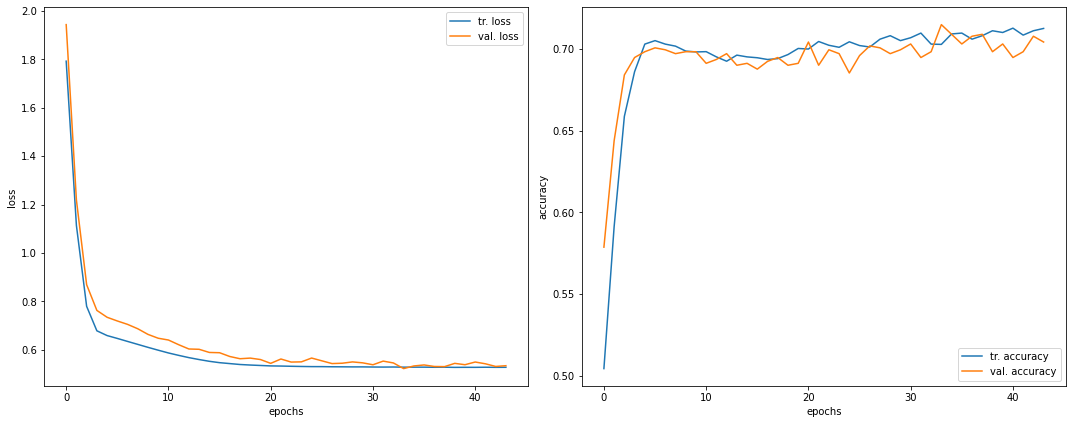

In [88]:
func.plot_training_history(history_lat)

In [89]:
tr_nn_lat_score, tr_nn_lat_metric = func.compute_metric(x_tr_encoded, Y_tr, nn_lat)
ts_nn_lat_score, ts_nn_lat_metric = func.compute_metric(x_ts_encoded, Y_ts, nn_lat)

print(f'TRAINING \n accuracy : {tr_nn_lat_metric} \n non-churned : {tr_nn_lat_score[0]:.3f} \n churn : {tr_nn_lat_score[1]:.3f}')
print(f'TESTING \n accuracy : {ts_nn_lat_metric}\n non-churned : {ts_nn_lat_score[0]:.3f} \n churn : {ts_nn_lat_score[1]:.3f} ')

TRAINING 
 accuracy : 0.72 
 non-churned : 0.684 
 churn : 0.823
TESTING 
 accuracy : 0.73
 non-churned : 0.714 
 churn : 0.778 


## Conclusion

We have seen several approachs to address the customer churn problem:
* classification approach
* anomaly detection approach
* autoencoder and exploitation of the latent space


The anomaly detection approach didn't work very well, while others approachs worked quite well, even if basic classifiers (non-neural classifier) struggle to predict churn customers.

In a future work, we could try to exploit others anomalies detection approachs, like Flow models.  
We could also try to increase the dimension of the latent space. Indeed, 2 is convenient only for plotting but we could, for example, try with a 15-th dimensional latent space and re-train a KNN algorithm or K-means but with cosine similarity as a distance metric.  
We could also use a Variational Autoencoder (VAE), which describe latent space in probabilistic terms, instead of a plain autoencoder. We can also use this kind of autoencoder to create data, it is a generative model.

## Further readings

Variational Autoencoder:
* https://www.jeremyjordan.me/variational-autoencoders/
* https://blog.keras.io/building-autoencoders-in-keras.html

Imbalanced dataset:
* https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

correctly initialize neural network:
* https://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines
